In [1]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, StableRNGs

  Activating project at `/ws`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0


#### Data Generation

In [2]:
s_init = [1, 0]
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [3]:
function rand_vec(rng, distribution::Categorical)
  k = ncategories(distribution)
  s = zeros(k)
  drawn_category = rand(rng, distribution)
  s[drawn_category] = 1
  return s
end

rand_vec (generic function with 1 method)

In [4]:
function generate_data(rng)
  # Emmision probabilities
  emission_prob = [0.7 0.3; 0.3 0.7]

  y_prob_vec = emission_prob * s_init
  y = rand_vec(rng, Categorical(y_prob_vec / sum(y_prob_vec)))

  return y
end

generate_data(rng)

2-element Vector{Float64}:
 1.0
 0.0

In [5]:
datastream   = RecentSubject(Vector{Float64})
observations = labeled(Val((:y, )), combineLatest(datastream))

LabeledObservable(@NamedTuple{y::Vector{Float64}}, Rocket.CombineLatestObservable{Tuple{Vector{Float64}}, Tuple{Rocket.RecentSubjectInstance{Vector{Float64}, Subject{Vector{Float64}, AsapScheduler, AsapScheduler}}}, PushEach})

##### Testing data generation

In [6]:
test_subscription = subscribe!(observations,
  (new_observation) -> println("Got new obersvation: ", new_observation)
)

CombineLatestSubscription()

In [7]:
for i in 1:5
  next!(datastream, generate_data(rng))
end

Got new obersvation: (y = [1.0, 0.0],)
Got new obersvation: (y = [0.0, 1.0],)
Got new obersvation: (y = [0.0, 1.0],)
Got new obersvation: (y = [1.0, 0.0],)
Got new obersvation: (y = [0.0, 1.0],)


In [8]:
unsubscribe!(test_subscription)

#### Model

In [9]:
@model function hidden_markov_model(_s_prev, y)
  A ~ MatrixDirichlet([100 1;
                       1 100])
  B ~ MatrixDirichlet([10 1;
                       1 10])

  s_prev ~ Categorical(_s_prev)

  s ~ Transition(s_prev, A)
  y ~ Transition(s, B)
end

@constraints function hidden_markov_model_constraints()
  q(s, s_prev, B, A) = q(s, s_prev)q(B)q(A)
end 

hidden_markov_model_autoupdates = @autoupdates begin
  _s_prev = params(q(s_prev))
end

@autoupdates begin
    _s_prev = params(q(s_prev))
end


In [10]:
imarginals = @initialization begin
  q(A) = vague(MatrixDirichlet, 2, 2)
  q(B) = vague(MatrixDirichlet, 2, 2)
  q(s) = vague(Categorical, 2)
  q(s_prev) = Categorical(fill(0.5, 2))
  q(y) = vague(Categorical, 2)
end

ireturnvars = (
  A = KeepLast(),
  B = KeepLast(),
  s = KeepLast()
)

engine = infer(
  model          = hidden_markov_model(),
  constraints    = hidden_markov_model_constraints(),
  datastream     = observations,
  autoupdates    = hidden_markov_model_autoupdates,
  initialization = imarginals,
  keephistory    = 100,
  historyvars    = ireturnvars,
  autostart      = false
)



RxInferenceEngine:
  Posteriors stream    | enabled for (A, s, B, s_prev)
  Free Energy stream   | disabled
  Posteriors history   | available for (A, s, B)
  Free Energy history  | unavailable
  Enabled events       | [  ]

#### Inferring

In [11]:
s_update_subscription = subscribe!(engine.posteriors[:s],
  (new_posterior_s) -> println("New posterior: ", new_posterior_s)
)

RxInfer.start(engine)

New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.5, 0.5])


In [12]:
for i in 1:100
  y = generate_data(rng)
  println("observation y: ", y)
  next!(datastream, y)
end

observation y: [1.0, 0.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.07549735257365202, 0.924502647426348])
observation y: [0.0, 1.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.6111707444948147, 0.38882925550518527])
observation y: [0.0, 1.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.07876816750085765, 0.9212318324991423])
observation y: [0.0, 1.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.0110926915038325, 0.9889073084961675])
observation y: [0.0, 1.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.0010964078400304638, 0.9989035921599695])
observation y: [1.0, 0.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.00037993639426019094, 0.9996200636057397])
observation y: [1.0, 0.0]
New posterior: Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.09466561

In [13]:
RxInfer.stop(engine)
unsubscribe!(s_update_subscription)

Any[Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.07549735257365202, 0.924502647426348]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.6111707444948147, 0.38882925550518527]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.07876816750085765, 0.9212318324991423]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.0110926915038325, 0.9889073084961675]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.0010964078400304638, 0.9989035921599695]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.00037993639426019094, 0.9996200636057397]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.09466561130296759, 0.9053343886970324]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.04754654284584693, 0.9524534571541531]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.07714414788803219, 0.9228558521119679]), Categorical{Float64, Vector{Fl

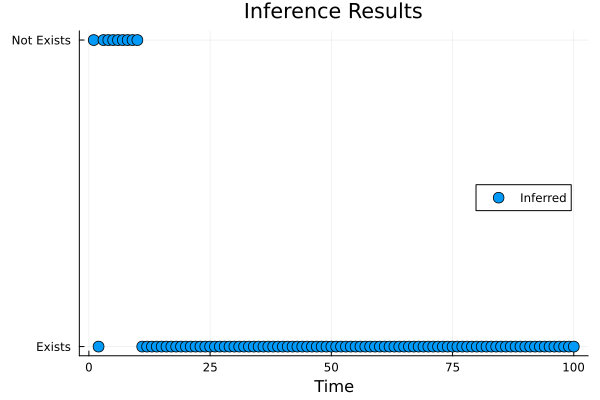

In [14]:
s = engine.history[:s]
println(s)

p1 = scatter(argmax.(ReactiveMP.probvec.(s)),
                        title = "Inference Results",
                        label = "Inferred",
                        ms = 6, 
                        legend = :right,
                        xlabel = "Time",
                        yticks = ([1, 2], ["Exists", "Not Exists"]),
                        #size = (900, 500)
                        )

plot(p1)